In [1]:
%%capture
!git clone git@github.com:rtqichen/torchdiffeq.git

In [2]:
!pip install -e torchdiffeq

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Obtaining file:///Users/sachour/Documents/git/research/legno-compiler/notebooks/prototype/torchdiffeq
  Found existing installation: torchdiffeq 0.0.1
    Uninstalling torchdiffeq-0.0.1:
      Successfully uninstalled torchdiffeq-0.0.1
  Running setup.py develop for torchdiffeq


In [3]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)


In [4]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import sys

In [5]:

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [6]:
viz = True
if viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

<Figure size 1200x400 with 3 Axes>

In [18]:
def visualize(true_y, pred_y, odefunc, itr):

    if viz:

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], \
                     t.numpy(), true_y.numpy()[:, 0, 1], 'g-', \
                     label='ground-truth')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--',  \
                     t.numpy(), pred_y.numpy()[:, 0, 1], 'b--', 
                     label='prediction')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr))
        plt.draw()
        plt.pause(0.001)

In [10]:
adjoint = True
data_size = 1000
niters = 2000
batch_time = 10
batch_size = 20
test_freq = 20

In [11]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [12]:
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y**3, true_A)

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        # the neural network we're learning
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

In [13]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), \
                                          batch_size, 
                                          replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y



In [14]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
# establish baseline truths
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')



In [15]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


In [16]:
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

In [20]:
ii = 0
print("=== training model ===")
losses = []
iters = []
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            losses.append(loss)
            iters.append(itr)
            #visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()

=== training model ===
Iter 0020 | Total Loss 0.462430
Iter 0040 | Total Loss 0.161764
Iter 0060 | Total Loss 0.163516
Iter 0080 | Total Loss 0.211697
Iter 0100 | Total Loss 0.203898
Iter 0120 | Total Loss 0.456389
Iter 0140 | Total Loss 0.717730
Iter 0160 | Total Loss 0.410492
Iter 0180 | Total Loss 0.161990
Iter 0200 | Total Loss 0.134207
Iter 0220 | Total Loss 0.589135
Iter 0240 | Total Loss 0.486150
Iter 0260 | Total Loss 0.293913
Iter 0280 | Total Loss 0.578175
Iter 0300 | Total Loss 0.127085
Iter 0320 | Total Loss 0.262630
Iter 0340 | Total Loss 0.168523
Iter 0360 | Total Loss 0.076132
Iter 0380 | Total Loss 0.628843
Iter 0400 | Total Loss 0.138040
Iter 0420 | Total Loss 0.235303
Iter 0440 | Total Loss 0.473255
Iter 0460 | Total Loss 0.444810
Iter 0480 | Total Loss 0.237422
Iter 0500 | Total Loss 0.230765
Iter 0520 | Total Loss 0.080407
Iter 0540 | Total Loss 0.718817
Iter 0560 | Total Loss 0.547025
Iter 0580 | Total Loss 0.367945
Iter 0600 | Total Loss 0.690149
Iter 0620 | Total

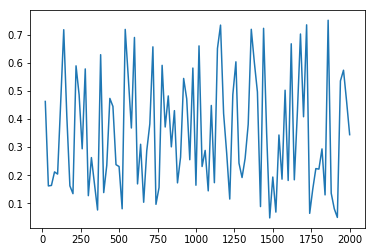

In [21]:
plt.plot(iters,losses)